In [10]:
!pip install langchain langchain_openai pdfplumber chromadb langchain_community --q
! pip install rank_bm25 --q

In [2]:
doc_list = [
    "I like apples",
    "I like oranges",
    "Apples and oranges are fruits",
    "I am still figuring out how to use Apple's macbook",
    "I don't have Apple's iPhone",
    "Macbook is very smooth and swift"
]

# BM25Retriever

 It is an enhancement of the traditional TF-IDF method, which considers the frequency of terms within a document (term frequency) and the rarity of terms across all documents (inverse document frequency) to compute relevance scores.

In [11]:
from langchain.retrievers import BM25Retriever
# initialize the bm25 retriever
bm25_retriever = BM25Retriever.from_texts(doc_list)
bm25_retriever.k = 2

In [12]:
bm25_retriever.get_relevant_documents("Apple")

[Document(page_content='Macbook is very smooth and swift'),
 Document(page_content="I don't have Apple's iPhone")]

In [13]:
bm25_retriever.get_relevant_documents("orange")

[Document(page_content='Macbook is very smooth and swift'),
 Document(page_content="I don't have Apple's iPhone")]

#  Maximal Marginal Relevance (MMR)

Maximal Marginal Relevance (MMR) is a method used in information retrieval to select documents that are both relevant to the query and diverse with respect to the previously selected documents. This approach helps in reducing redundancy and increasing the coverage of different aspects of the query in the selected documents.

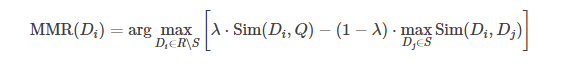


Steps:

1. Compute Relevance Score:  Sim(Di,Q)
  for each candidate document  Di
  with respect to the query  Q
2. Compute Diversity Score:  maxDj∈SSim(Di,Dj)
  for each candidate document  Di
  with respect to the selected documents  S
3. Calculate MMR Score:  λ⋅Sim(Di,Q)−(1−λ)⋅maxDj∈SSim(Di,Dj)
4. Select Document: Choose the document  Di
  with the highest MMR score and add it to the selected set  S

In [4]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')

from langchain_openai import OpenAIEmbeddings

In [5]:
from langchain.vectorstores import Chroma

# load embeddings into Chroma - need to pass docs , embedding function and path of the db

db = Chroma.from_texts(doc_list,
                       embedding=OpenAIEmbeddings())

In [6]:
retriever_mmr = db.as_retriever(search_type="mmr", search_kwargs={"k": 2})

In [7]:
retriever_mmr.get_relevant_documents("Apple")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='I like apples'),
 Document(page_content='Macbook is very smooth and swift')]

In [8]:
retriever_mmr.get_relevant_documents("orange")

[Document(page_content='I like oranges'),
 Document(page_content='Macbook is very smooth and swift')]

# Vanilla RAG
Based on semantic similarity

In [14]:
retriever_vanilla = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [15]:
retriever_mmr.get_relevant_documents("Apple")

[Document(page_content='I like apples'),
 Document(page_content='Macbook is very smooth and swift')]

In [16]:
retriever_mmr.get_relevant_documents("orange")

[Document(page_content='I like oranges'),
 Document(page_content='Macbook is very smooth and swift')]

# Ensemble Retriever

Uses Reciprocal Ranking to merge documents and rerank the documents-

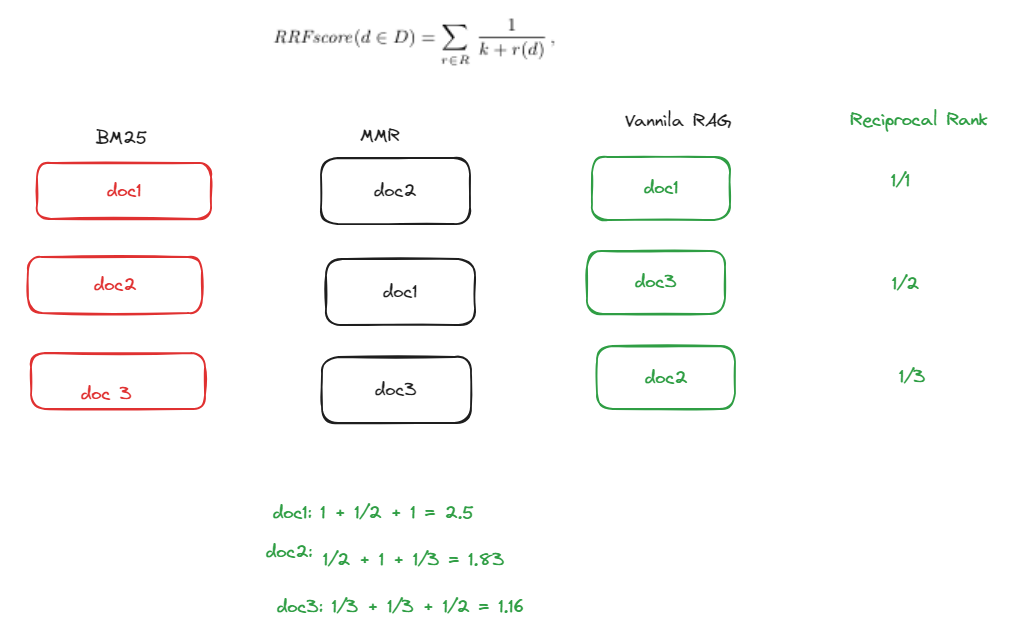

In [29]:
from langchain.retrievers import EnsembleRetriever


# initialize the ensemble retriever with 3 Retrievers
ensemble_retriever = EnsembleRetriever(
    retrievers=[retriever_vanilla, retriever_mmr, bm25_retriever], weights=[0.33, 0.33, 0.33]
)

In [30]:
ensemble_retriever.get_relevant_documents("Apple")

[Document(page_content='I like apples'),
 Document(page_content='Macbook is very smooth and swift'),
 Document(page_content="I don't have Apple's iPhone")]

In [31]:
ensemble_retriever.get_relevant_documents("orange")

[Document(page_content='I like oranges'),
 Document(page_content='Macbook is very smooth and swift'),
 Document(page_content='Apples and oranges are fruits'),
 Document(page_content="I don't have Apple's iPhone")]